In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
DATE = '2024-01-02'

FILE_DATA = f'steepener_trade_{DATE}.xlsx'

info = pd.read_excel(FILE_DATA,sheet_name='info').set_index('KYTREASNO').T
clean = pd.read_excel(FILE_DATA,sheet_name='clean price').set_index('quote date')
dirty = pd.read_excel(FILE_DATA,sheet_name='dirty price').set_index('quote date')
duration = pd.read_excel(FILE_DATA,sheet_name='duration').set_index('quote date')

### 1.1.

Consider the first date of the sample for which you have prices and duration data.

Construct the trade such that you are zero net dollar duration.

- What is the dollar value of your short position (against your 50 million long)
- How many 2-year bonds? (Assume you can have fractional bonds.)
- How many 10-year bonds? (Assume you can have fractional bonds.)

In [ ]:
NOTIONAL_LONG_2Y = 50_000_000
FACE_VALUE = 100

ID_2Y  = 207652
ID_10Y = 208147

first_date = dirty.index[0]

P_2y = dirty.loc[first_date, ID_2Y]
D_2y = duration.loc[first_date, ID_2Y]

P_10y = dirty.loc[first_date, ID_10Y]
D_10y = duration.loc[first_date, ID_10Y]


# Calculate number of 2y bonds to long
num_2y = NOTIONAL_LONG_2Y / FACE_VALUE

# Calculate dollar duation of the long position
dd_long = num_2y * P_2y * D_2y

# Calculate number of 10y bonds to short
num_10y = dd_long / (P_10y * D_10y)

# Calculate market value of the short position
market_value_short = num_10y * P_10y

print(f"Trade Setup for {first_date}")
print(f"2-Year Price: ${P_2y:.2f}")
print(f"2-Year Duration: {D_2y:.4f}")
print(f"10-Year Price: ${P_10y:.2f}")
print(f"10-Year Duration: {D_10y:.4f}")
print("-" * 30)
print(f"1. Dollar Value of Short Position: ${market_value_short:,.2f}")
print(f"2. Number of 2-year bonds: {num_2y:,.2f}")
print(f"3. Number of 10-year bonds: {num_10y:,.2f}")

Trade Setup for 2023-11-09 00:00:00
2-Year Price: $90.98
2-Year Duration: 2.1352
10-Year Price: $99.00
10-Year Duration: 8.1737
------------------------------
1. Dollar Value of Short Position: $11,882,965.53
2. Number of 2-year bonds: 500,000.00
3. Number of 10-year bonds: 120,029.95


### 1.2.

For each date in the time-series, re-calculate the the position sizes and hedge ratio to set dollar duration to zero.

Plot the timeseries across the ...
- the hedge ratio over time.

- the number of 2 years to keep at 50 million notional long.

- the number of 10 year bonds.

Report the values for the last date in the sample.

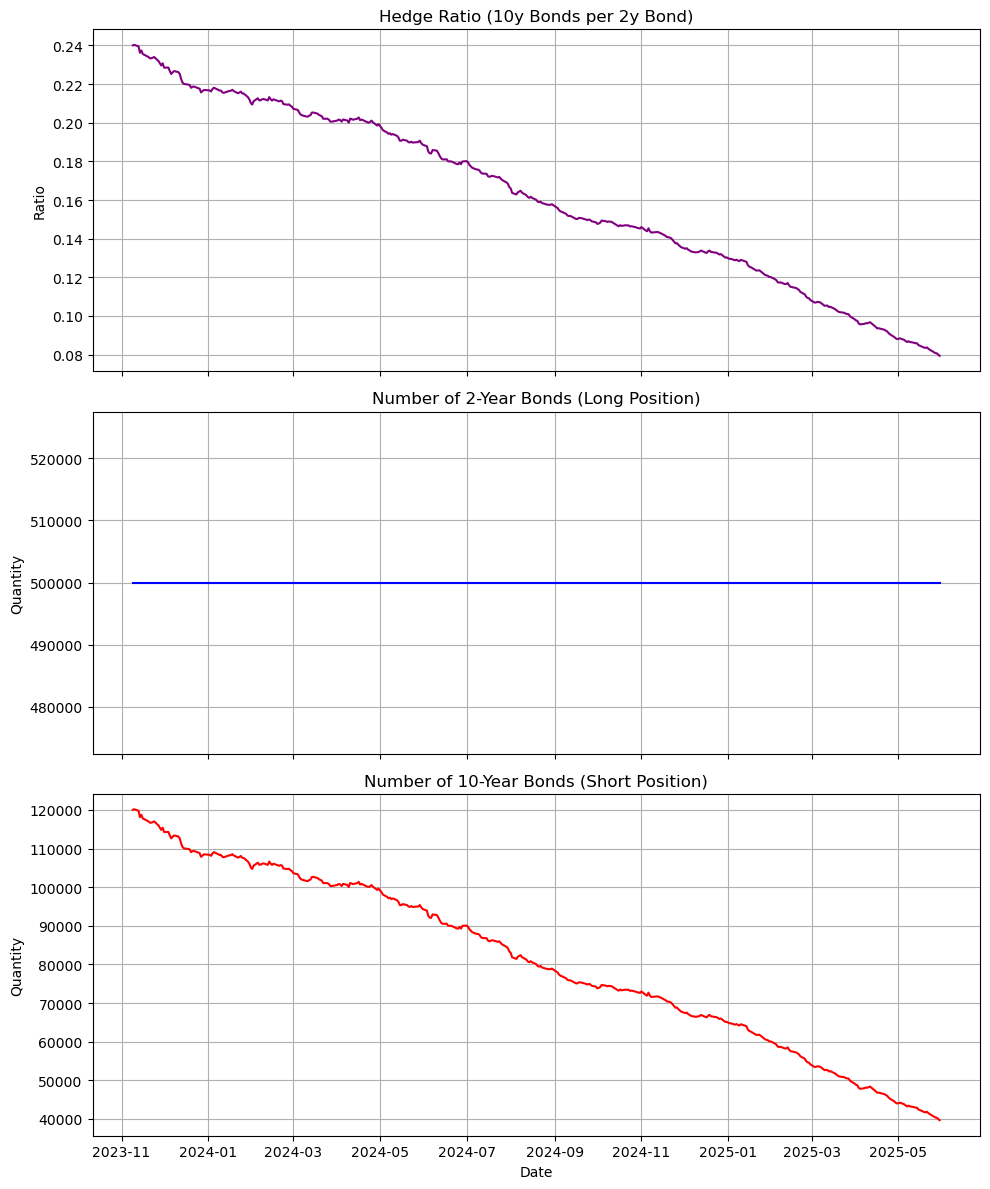

--- Values for Last Date: 2025-05-30 ---
Hedge Ratio: 0.0794
Num 2-Year Bonds: 500,000.0000
Num 10-Year Bonds: 39,694.7381


In [ ]:
df_calc = pd.DataFrame(index=dirty.index)
df_calc['num_2y'] = NOTIONAL_LONG_2Y / FACE_VALUE

# Get price and duration for 2yr
P_2y = dirty[ID_2Y]
D_2y = duration[ID_2Y]

df_calc['dd_long'] = df_calc['num_2y'] * P_2y * D_2y

# Price and duration for 10yr
P_10y = dirty[ID_10Y]
D_10y = duration[ID_10Y]

df_calc['num_10y'] = df_calc['dd_long'] / (P_10y * D_10y)
df_calc['hedge_ratio'] = df_calc['num_10y'] / df_calc['num_2y']


fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Hedge Ratio
axes[0].plot(df_calc.index, df_calc['hedge_ratio'], color='purple')
axes[0].set_title('Hedge Ratio (10y Bonds per 2y Bond)')
axes[0].set_ylabel('Ratio')
axes[0].grid(True)

# Number of 2-Year Bonds
axes[1].plot(df_calc.index, df_calc['num_2y'], color='blue')
axes[1].set_title('Number of 2-Year Bonds (Long Position)')
axes[1].set_ylabel('Quantity')
axes[1].grid(True)

# Number of 10-Year Bonds
axes[2].plot(df_calc.index, df_calc['num_10y'], color='red')
axes[2].set_title('Number of 10-Year Bonds (Short Position)')
axes[2].set_ylabel('Quantity')
axes[2].set_xlabel('Date')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Last Date Values
last_date = df_calc.index[-1]
last_vals = df_calc.iloc[-1]

print(f"--- Values for Last Date: {last_date.date()} ---")
print(f"Hedge Ratio: {last_vals['hedge_ratio']:.4f}")
print(f"Num 2-Year Bonds: {last_vals['num_2y']:,.4f}")
print(f"Num 10-Year Bonds: {last_vals['num_10y']:,.4f}")

### 1.3.

Calculate the profit and loss of your trade.

Be careful to note that your positioning at time t is scaled by the price change from t to t+1. (Your profit today depends on your positioning yesterday .)

Report the first and last day’s profit for the 2yr, 10yr, and net difference.

In [ ]:
# Calculate price changes
delta_p_2y = dirty[ID_2Y].diff()
delta_p_10y = dirty[ID_10Y].diff()

# Get "yesterday's" position
pos_2y_lag = df_calc['num_2y'].shift(1)
pos_10y_lag = df_calc['num_10y'].shift(1)

# Long PnL
df_calc['pnl_2y'] = pos_2y_lag * delta_p_2y

# Short PnL
df_calc['pnl_10y'] = -pos_10y_lag * delta_p_10y

# Net PnL
df_calc['pnl_net'] = df_calc['pnl_2y'] + df_calc['pnl_10y']

df_pnl = df_calc.dropna()

first_date = df_pnl.index[0]
last_date = df_pnl.index[-1]

print(f"--- PnL Report ---")
print(f"First Day Profit ({first_date.date()}):")
print(f"2yr PnL: ${df_pnl.loc[first_date, 'pnl_2y']:,.2f}")
print(f"10yr PnL: ${df_pnl.loc[first_date, 'pnl_10y']:,.2f}")
print(f"Net PnL: ${df_pnl.loc[first_date, 'pnl_net']:,.2f}")
print("-" * 30)
print(f"Last Day Profit ({last_date.date()}):")
print(f"2yr PnL: ${df_pnl.loc[last_date, 'pnl_2y']:,.2f}")
print(f"10yr PnL: ${df_pnl.loc[last_date, 'pnl_10y']:,.2f}")
print(f"Net PnL: ${df_pnl.loc[last_date, 'pnl_net']:,.2f}")

--- PnL Report ---
First Day Profit (2023-11-10):
2yr PnL: $-19,021.74
10yr PnL: $25,318.82
Net PnL: $6,297.08
------------------------------
Last Day Profit (2025-05-30):
2yr PnL: $15,615.86
10yr PnL: $-11,498.14
Net PnL: $4,117.72


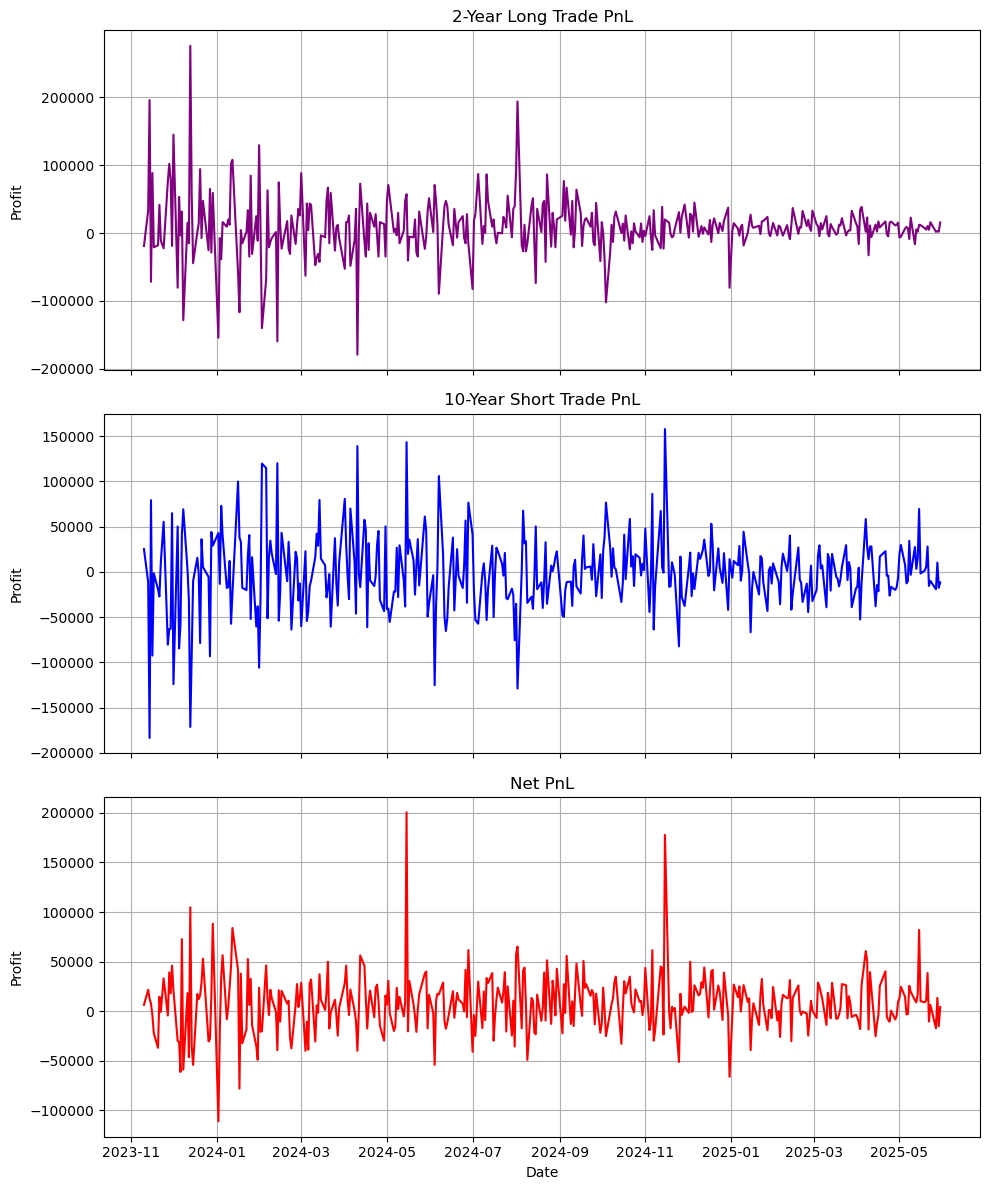

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# 2yr PnL
axes[0].plot(df_pnl.index, df_pnl['pnl_2y'], color='purple')
axes[0].set_title('2-Year Long Trade PnL')
axes[0].set_ylabel('Profit')
axes[0].grid(True)

# 10yr PnL
axes[1].plot(df_pnl.index, df_pnl['pnl_10y'], color='blue')
axes[1].set_title('10-Year Short Trade PnL')
axes[1].set_ylabel('Profit')
axes[1].grid(True)

# Net PnL
axes[2].plot(df_pnl.index, df_pnl['pnl_net'], color='red')
axes[2].set_title('Net PnL')
axes[2].set_ylabel('Profit')
axes[2].set_xlabel('Date')
axes[2].grid(True)

plt.tight_layout()
plt.show()

### 1.5.

Your profit above ignored coupons.

Calculate the timeseries of coupons for the 2yr and 10yr. Add these coupons to the net PnL calculated above.

- Report the cumulative profit over the entire sample with the coupons, compared to your answer above without the coupons.

In [ ]:
cpn_rate_2y = info[ID_2Y]['cpn rate']
cpn_rate_10y = info[ID_10Y]['cpn rate']

issue_date_2y = pd.to_datetime(info[ID_2Y]['issue date'])
issue_date_10y = pd.to_datetime(info[ID_10Y]['issue date'])

is_coupon_2y = (abs(dirty[ID_2Y] - clean[ID_2Y]) == 0) & (dirty.index > issue_date_2y)
is_coupon_10y = (abs(dirty[ID_10Y] - clean[ID_10Y]) == 0) & (dirty.index > issue_date_10y)

payment_2y = FACE_VALUE * (cpn_rate_2y / 100) / 2
payment_10y = FACE_VALUE * (cpn_rate_10y / 100) / 2

pos_2y_lag = df_calc['num_2y'].shift(1).fillna(0)
pos_10y_lag = df_calc['num_10y'].shift(1).fillna(0)

# Calculate daily coupon PnL
cpn_pnl_2y = pos_2y_lag * payment_2y * is_coupon_2y
cpn_pnl_10y = -pos_10y_lag * payment_10y * is_coupon_10y

# Calculate net PnL including coupons
pnl_net_total = df_calc['pnl_net'] + cpn_pnl_2y + cpn_pnl_10y
cum_pnl_price = df_calc['pnl_net'].sum()
cum_pnl_total = pnl_net_total.sum()


print(f"Total Profit (Price Only):    ${cum_pnl_price:,.2f}")
print(f"Total Profit (With Coupons):  ${cum_pnl_total:,.2f}")
print(f"Difference (Coupon Impact):   ${cum_pnl_total - cum_pnl_price:,.2f}")

--- Cumulative Profit Report ---
Total Profit (Price Only):    $3,043,663.49
Total Profit (With Coupons):  $2,663,572.89
Difference (Coupon Impact):   $-380,090.60
